In [20]:
import numpy as np
import matplotlib.pyplot as plt
from keras import callbacks as cb
import os, json, math, librosa
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

In [7]:
dir_ = "../Data"
df = pd.read_csv(f'{dir_}/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
print(df.columns)

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

## Explanation of Features

1. **Chromagram Features (chroma_stft_mean and chroma_stft_var):**

+ **chroma_stft_mean:** The mean of the chroma short-time Fourier transform (STFT) features. These features represent the energy distribution of pitches.
+ **chroma_stft_var:** The variance of the chroma STFT features over time.

2. **Root Mean Square Energy (rms_mean and rms_var):**

+ **rms_mean:** The mean of the root mean square (RMS) energy of the audio, which is a measure of the audio's energy.
+ **rms_var:** The variance of the RMS values over time.

3. **Spectral Centroid (spectral_centroid_mean and spectral_centroid_var):**

+ **spectral_centroid_mean:** The mean of the spectral centroid, which represents the center of mass of the spectrum. It provides information about the brightness of the sound.
+ **spectral_centroid_var:** The variance of the spectral centroid over time.

4. **Spectral Bandwidth (spectral_bandwidth_mean and spectral_bandwidth_var):**

+ **spectral_bandwidth_mean:** The mean of the spectral bandwidth, which describes the width of the spectral band.
+ **spectral_bandwidth_var:** The variance of the spectral bandwidth over time.

5. **Spectral Rolloff (rolloff_mean and rolloff_var):**

+ **rolloff_mean:** The mean of the spectral roll-off, which represents the frequency below which a specified percentage of the total spectral energy lies.
+ **rolloff_var:** The variance of the spectral roll-off over time. 

6. **Zero Crossing Rate (zero_crossing_rate_mean and zero_crossing_rate_var):**
+ **zero_crossing_rate_mean:** The mean of the zero-crossing rate, which indicates how often the signal changes its sign. It can provide information about noisiness or percussiveness.
+ **zero_crossing_rate_var:** The variance of the zero-crossing rate over time.

7. **Harmonic and Perceptrual Features (harmony_mean, harmony_var, perceptr_mean, and perceptr_var):**
+ **harmony_mean and harmony_var:** These features capture harmonic content in the audio signal.
+ **perceptr_mean and perceptr_var:** These features capture perceptual attributes of the audio signal. These are less common features and may be specific to the dataset or analysis.

8. **Tempo (tempo):**
+ **tempo:** Represents the tempo of the audio, which is the number of beats per minute (BPM).

9. **Mel-Frequency Cepstral Coefficients (MFCCs):**
+ The code computes 20 MFCCs for each audio file, both the mean and variance of each. MFCCs are coefficients that represent the shape of the power spectrum of the audio. They are often used for speech and audio analysis.


## Correlation Heatmap for features

/tmp/ipykernel_142679/1002904529.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


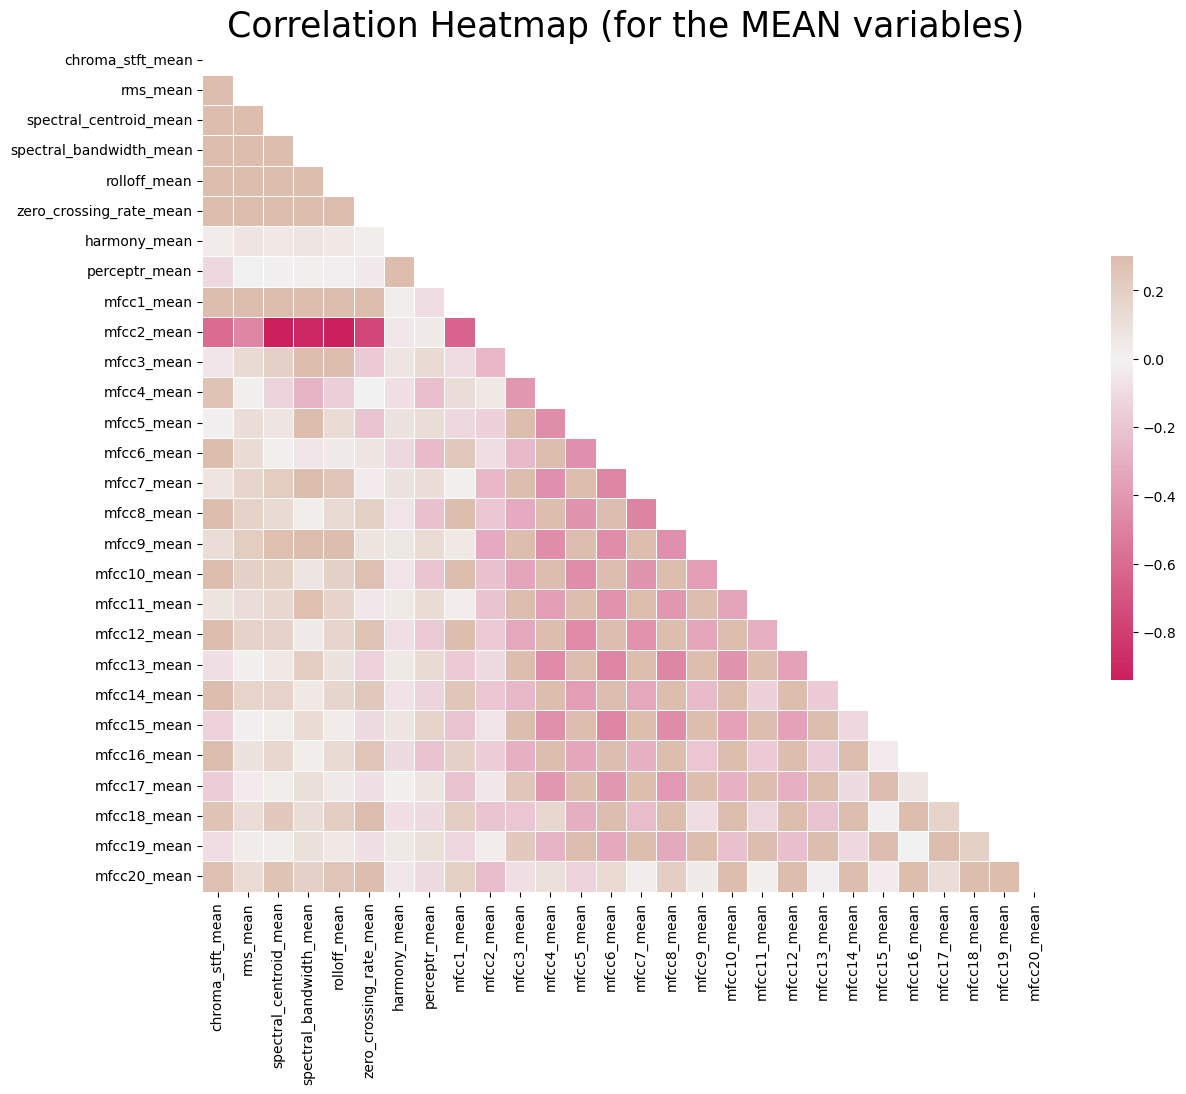

In [10]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

## Box Plot for Genre Distributiona

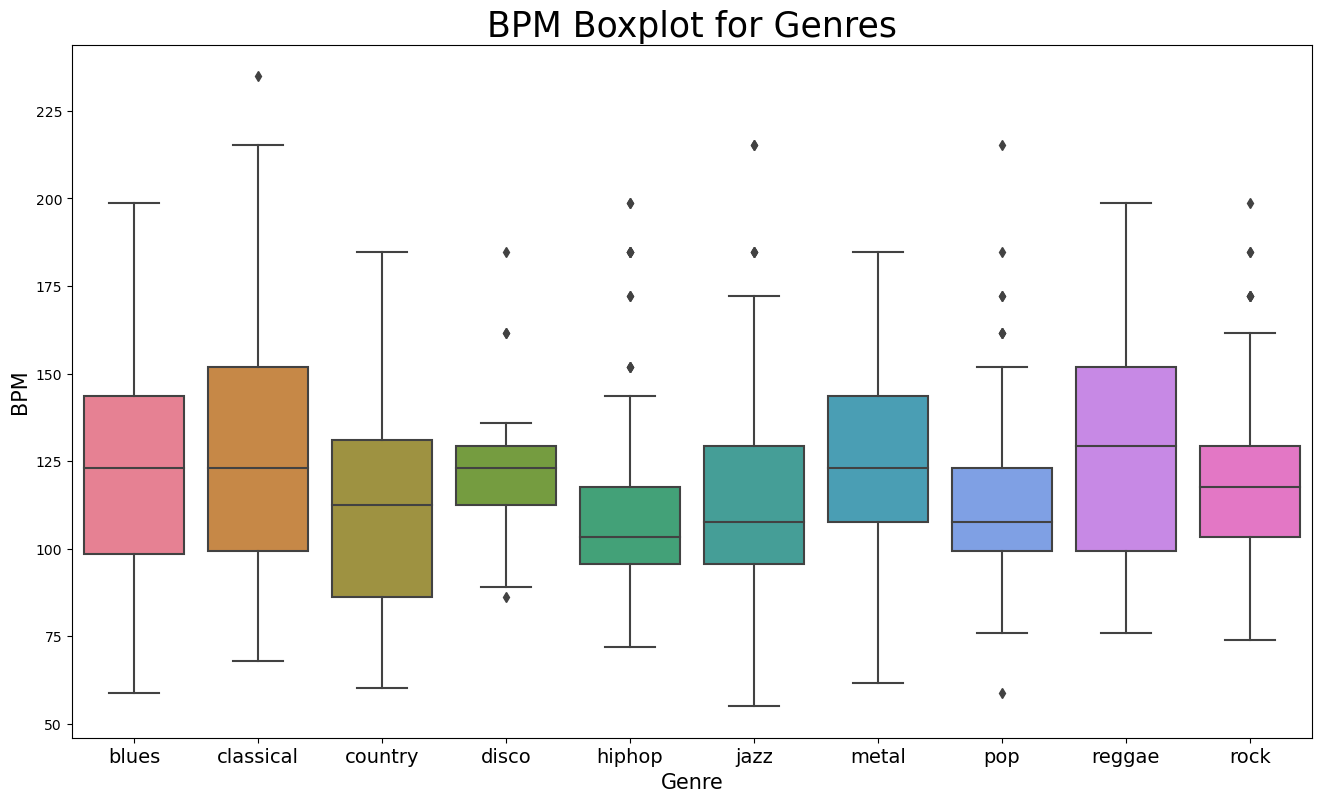

In [11]:
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

## Principal Component Analysis (PCA) 
To visualize distribution of possible clusters

In [12]:
# Slice the DataFrame to keep all rows (0:) and all columns except the first (1:)
df = pd.read_csv(f'{dir_}/features_30_sec.csv')
df = df.iloc[0:, 1:]

# Create a target variable 'y' by selecting the 'label' column from the DataFrame
y = df['label']

# Create a feature matrix 'X' by selecting all columns from the DataFrame except 'label'
X = df.loc[:, df.columns != 'label']

# Normalize the feature matrix 'X' using Min-Max scaling
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Perform Principal Component Analysis (PCA) with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Create a DataFrame to hold the two principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Concatenate the principal components DataFrame with the target variable 'y'
finalDf = pd.concat([principalDf, y], axis = 1)

# Retrieve the explained variance ratio for each principal component
pca.explained_variance_ratio_

array([0.2439355 , 0.21781804])

+ The first principal component explains approximately 24.39% of the total variance in the data.
+ The second principal component explains approximately 21.78% of the total variance in the data.

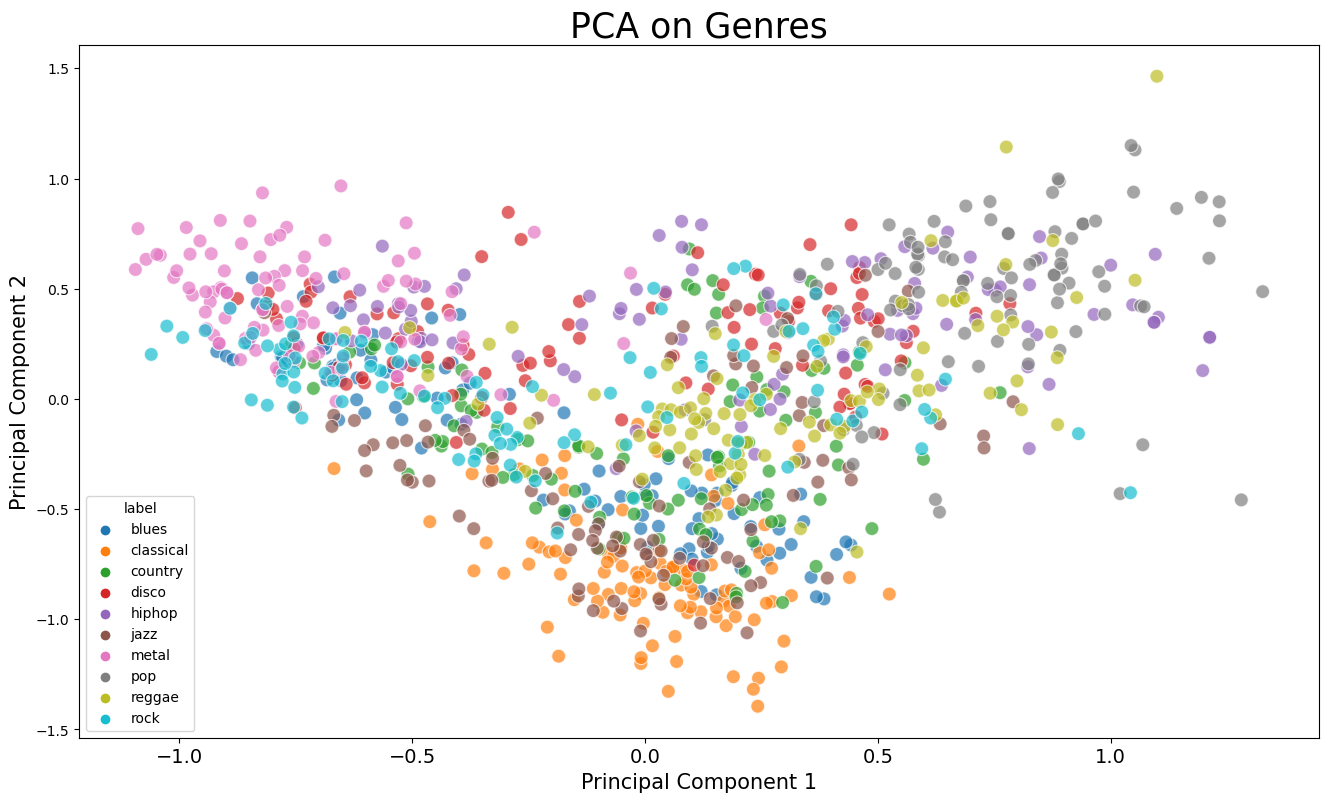

In [13]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

In [14]:
df = pd.read_csv(f'{dir_}/features_3_sec.csv')

genre_list = df.iloc[:, -1]
encoder = preprocessing.LabelEncoder()

df = df.iloc[0:, 1:] 
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [15]:
# Create a target variable 'y' by selecting the 'label' column from the DataFrame
y = encoder.fit_transform(genre_list)

# Create a feature matrix 'X' by selecting all columns from the DataFrame except 'label'
X = df.loc[:, df.columns != 'label']

# Normalize the feature matrix 'X' using Min-Max scaling
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

## Splitting the data into Training and Testing sets
+ 70% - 30% split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

### Naive Bayes Classifier

In [36]:
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

Accuracy Naive Bayes : 0.51952 



### Stochastic Gradient Descent

In [14]:
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

Accuracy Stochastic Gradient Descent : 0.65532 



### K-Nearest Neighbors

In [15]:
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

Accuracy KNN : 0.80581 



/home/sanyam/anaconda3/envs/MGC/lib/python3.8/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### Decision Tree Classifier

In [16]:
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

Accuracy Decission trees : 0.63797 



### Random Forest Classifier

In [17]:
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

Accuracy Random Forest : 0.81415 



### Support Vector Machine

In [18]:
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

Accuracy Support Vector Machine : 0.75409 



### Logistic Regression

In [37]:
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

Accuracy Logistic Regression : 0.6977 



/home/sanyam/anaconda3/envs/MGC/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Neural Network

In [20]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

/home/sanyam/anaconda3/envs/MGC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy Neural Nets : 0.67334 



### Cross Gradient Booster

In [38]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

Accuracy Cross Gradient Booster : 0.9009 



### Cross Gradient Booster (Random Forest)

In [39]:
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Cross Gradient Booster (Random Forest) : 0.74575 



## Accuracy Scores
+ Naive Bayes : 0.51952
+ Stochastic Gradient Descent : 0.65532 
+ KNN : 0.80581 
+ Decission trees : 0.63797 
+ Random Forest : 0.81415 
+ Support Vector Machine : 0.75409 
+ Logistic Regression : 0.6977
+ Neural Nets : 0.67334 
+ Cross Gradient Booster : 0.9009
+ Cross Gradient Booster (Random Forest) : 0.74575 

Accuracy : 0.9009 



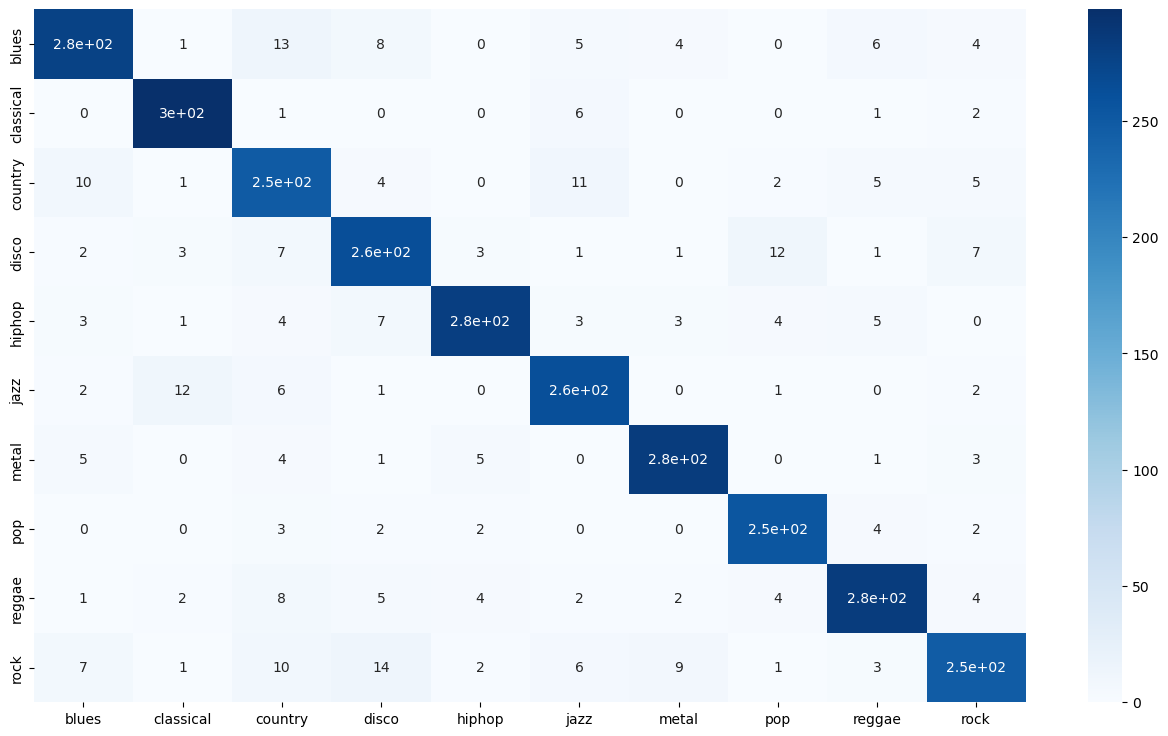

In [18]:
# Final model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("Confusion Matrix")

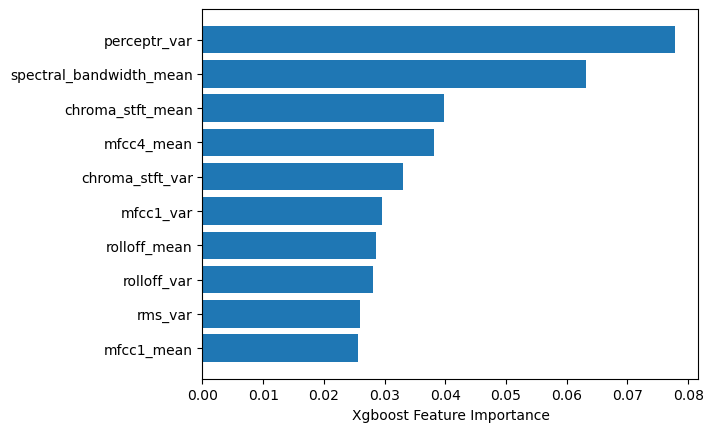

In [24]:
# sort the features by importance
sorted_idx = xgb.feature_importances_.argsort()
sorted_idx = sorted_idx[-10:]
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.savefig("Feature Importance.jpg")